# **Eduardo Gerab**

Nesta etapa carregamos o dataset Student Exam Performance Prediction e fizemos uma inspeção inicial. Isso inclui visualizar algumas linhas, verificar tipos das colunas e procurar valores faltantes. Essa análise ajuda a entender o formato dos dados, identificar possíveis problemas e decidir quais tratamentos serão necessários antes de treinar o modelo.

In [40]:
from google.colab import files
uploaded = files.upload()
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import trange

Saving student_exam_data.csv to student_exam_data (6).csv


In [41]:
import pandas as pd

df = pd.read_csv('student_exam_data.csv')
df.head()


,Study Hours,Previous Exam Score,Pass/Fail
0,4.370861,81.889703,0
1,9.556429,72.165782,1
2,7.587945,58.571657,0
3,6.387926,88.827701,1
4,2.404168,81.083870,0


Aqui realizamos o pré-processamento, que envolve transformar variáveis categóricas em numéricas, normalizar colunas e preparar os dados para o PyTorch. Esse passo é fundamental porque modelos de regressão logística exigem tensores numéricos e dados organizados, evitando erros e garantindo que o treinamento ocorra corretamente.

Também ocorre a divisão em conjuntos de treino e teste para avaliar o desempenho real do modelo. O treino permite que o modelo aprenda padrões, enquanto o teste mede a capacidade de generalização para dados nunca vistos. Essa etapa evita overfitting e garante avaliação justa.

In [42]:
possible_targets = ['passed','pass','status','result','target','passed_exam']
cols = df.columns.str.lower().tolist()
TARGET = None
for name in possible_targets:
    if name in cols:
        TARGET = df.columns[cols.index(name)]
        break
if TARGET is None:
    # fallback: última coluna do dataframe
    TARGET = df.columns[-1]

print("Using target column:", TARGET)

# separar X e y
X = df.drop(columns=[TARGET])
y = df[TARGET]

# encoding rápido: one-hot para categoricas, numéricas mantidas
X = pd.get_dummies(X, drop_first=True)

# se y for categórico não numérico, converter para 0/1 (ou integers)
if y.dtype == 'O' or y.dtype.name.startswith('category'):
    y = pd.factorize(y)[0]

# escalonar as features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)

# split train/val/test (60/20/20)
X_train, X_tmp, y_train, y_tmp = train_test_split(X_scaled, y.values, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp)

print("shapes -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)


Using target column: Pass/Fail
shapes -> train: (300, 2) val: (100, 2) test: (100, 2)


Definimos uma rede simples com uma camada linear seguida de uma função sigmoid. Esse é o formato clássico da Regressão Logística. O objetivo é classificar se o aluno terá bom desempenho ou não com base nos atributos fornecidos. Também configuramos a função de perda e o otimizador.

In [43]:
batch_size = 32

train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                         torch.tensor(y_train, dtype=torch.long))   # long para CrossEntropy
val_ds = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                       torch.tensor(y_val, dtype=torch.long))
test_ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                        torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print("len(train_loader) batches:", len(train_loader))
print("len(train_ds):", len(train_ds))

len(train_loader) batches: 10
len(train_ds): 300


In [44]:
input_dim = X_train.shape[1]

n_classes = len(np.unique(y_train))

model = nn.Sequential(
    nn.Linear(input_dim, n_classes)
)
print(model)


Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
)


In [45]:
criterion = nn.CrossEntropyLoss()   # logit outputs + integer labels
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
n_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
)

Nesta parte ocorre o loop de treinamento. A cada época, o modelo calcula a previsão, mede o erro, ajusta os pesos e repete o ciclo. Também monitoramos a perda ao longo do tempo para verificar se o modelo está realmente aprendendo e convergindo para uma solução melhor.

In [46]:
loss_history = []
val_loss_history = []


for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)

    loss_avg = running_loss / total
    train_acc = correct / total

    loss_history.append(loss_avg)

    # validação simples (opcional)
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == yb).sum().item()
            val_total += xb.size(0)
    val_acc = val_correct / val_total if val_total>0 else 0.0
    val_loss_history.append(loss.item())

    print(f"Epoch {epoch+1}/{n_epochs} - loss: {loss_avg:.4f} - train_acc: {train_acc:.4f} - val_acc: {val_acc:.4f}")


Epoch 1/30 - loss: 0.5987 - train_acc: 0.7967 - val_acc: 0.8100
Epoch 2/30 - loss: 0.5808 - train_acc: 0.8233 - val_acc: 0.8300
Epoch 3/30 - loss: 0.5644 - train_acc: 0.8267 - val_acc: 0.8500
Epoch 4/30 - loss: 0.5499 - train_acc: 0.8267 - val_acc: 0.8600
Epoch 5/30 - loss: 0.5364 - train_acc: 0.8300 - val_acc: 0.8600
Epoch 6/30 - loss: 0.5240 - train_acc: 0.8333 - val_acc: 0.8600
Epoch 7/30 - loss: 0.5127 - train_acc: 0.8433 - val_acc: 0.8600
Epoch 8/30 - loss: 0.5022 - train_acc: 0.8467 - val_acc: 0.8500
Epoch 9/30 - loss: 0.4927 - train_acc: 0.8467 - val_acc: 0.8600
Epoch 10/30 - loss: 0.4839 - train_acc: 0.8533 - val_acc: 0.8600
Epoch 11/30 - loss: 0.4755 - train_acc: 0.8567 - val_acc: 0.8600
Epoch 12/30 - loss: 0.4680 - train_acc: 0.8533 - val_acc: 0.8700
Epoch 13/30 - loss: 0.4608 - train_acc: 0.8533 - val_acc: 0.8700
Epoch 14/30 - loss: 0.4541 - train_acc: 0.8567 - val_acc: 0.8800
Epoch 15/30 - loss: 0.4480 - train_acc: 0.8600 - val_acc: 0.8800
Epoch 16/30 - loss: 0.4421 - train

Aqui calculamos a acurácia e comparamos as previsões com os valores reais. Essa etapa mostra o quão bem a Regressão Logística conseguiu capturar a relação entre as variáveis dos estudantes e seu desempenho no exame.

In [47]:
model.eval()
test_correct = 0
test_total = 0
all_preds = []
all_targets = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        preds = torch.argmax(logits, dim=1)
        test_correct += (preds == yb).sum().item()
        test_total += xb.size(0)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(yb.cpu().numpy())

test_acc = test_correct / test_total
print("Test accuracy:", test_acc)

# optional: save
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler': scaler
}, "logreg_student_exam.pt")
print("Saved model to logreg_student_exam.pt")


Test accuracy: 0.87
Saved model to logreg_student_exam.pt


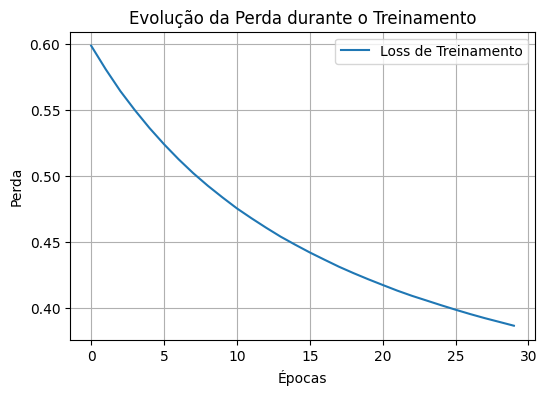

<Figure size 500x500 with 0 Axes>

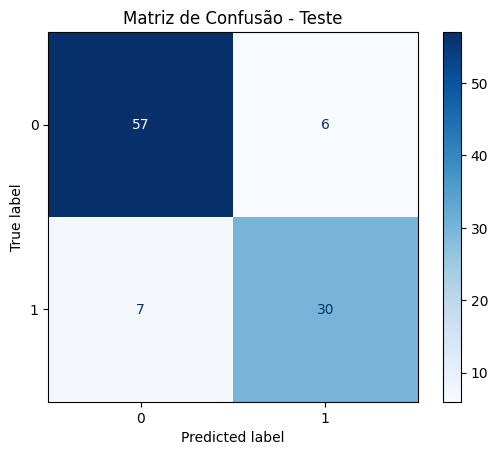


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90        63
           1       0.83      0.81      0.82        37

    accuracy                           0.87       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.87      0.87      0.87       100



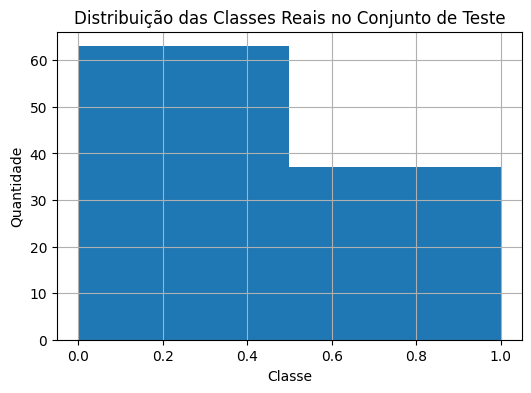

In [49]:
# ---------------------------
# GRÁFICO DA PERDA (Loss)
# ---------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(loss_history, label="Loss de Treinamento")
plt.xlabel("Épocas")
plt.ylabel("Perda")
plt.title("Evolução da Perda durante o Treinamento")
plt.legend()
plt.grid(True)
plt.show()


# ---------------------------
# MATRIZ DE CONFUSÃO
# ---------------------------
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds_flat = np.concatenate(all_preds)
all_targets_flat = np.concatenate(all_targets)

cm = confusion_matrix(all_targets_flat, all_preds_flat)

plt.figure(figsize=(5,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de Confusão - Teste")
plt.show()


# ---------------------------
# CLASSIFICATION REPORT
# ---------------------------
from sklearn.metrics import classification_report

print("\nRelatório de Classificação:")
print(classification_report(all_targets_flat, all_preds_flat))


# ---------------------------
# DISTRIBUIÇÃO DAS CLASSES
# ---------------------------
plt.figure(figsize=(6,4))
plt.hist(all_targets_flat, bins=len(np.unique(all_targets_flat)))
plt.title("Distribuição das Classes Reais no Conjunto de Teste")
plt.xlabel("Classe")
plt.ylabel("Quantidade")
plt.grid(True)
plt.show()


### Conclusão

Esse exercício ajudou a entender na prática como montar uma Regressão Logística completa usando PyTorch, passando por todas as etapas — desde explorar os dados, pré-processar, criar o modelo, treinar e avaliar. Foi possível ver como escolhas como normalização, forma do dataset e redução de categorias influenciam diretamente o resultado, além de reforçar a importância de acompanhar a perda e medir a acurácia para validar o aprendizado. No geral, o fluxo mostrou claramente como transformar um dataset bruto em um modelo funcional capaz de fazer previsões reais.